In [1]:
import os
import numpy as np
import pickle
import pandas as pd
from tqdm import tqdm

In [2]:
GLOVE_DIR = 'drive/MyDrive/Milestone2/glove.6B.100d.txt'
glove_dict = {}
with open(GLOVE_DIR) as f:
    for line in f:
        word, *vector = line.split()
        glove_dict[word]=np.array(vector).astype(float)

re_tokenized = pickle.load(open('drive/MyDrive/Milestone2/re_tokenized_lemma.pkl','rb'))

In [3]:
def get_average_glove_vec(list_of_tokens):
    avg_vec=[]
    for token in list_of_tokens:
    if token in glove_dict:
        avg_vec.append(glove_dict[token])

    if len(avg_vec)>0:
    avg_vec = np.mean(avg_vec, axis=0)
    else:
    avg_vec = np.zeros(100)

    return avg_vec

In [4]:
import pandas as pd
from tqdm import tqdm

import glob

# load precalculated features
path='sample_data/'
feature_files = glob.glob(path+"WikiLarge_Train_*2.csv")
features = []
for f in feature_files:
    temp = pd.read_csv(f, index_col=0)
    features.append(temp)
feature_df = pd.concat(features, axis=1)
feature_df = feature_df.fillna(feature_df.mean())

df = pd.read_csv(path+'WikiLarge_Train.csv')
feature_df = pd.concat([df, feature_df], axis=1)
chosen_features = ['aoa', 'concrete_score','verb2', 'conc_unknown', 'aoa_perc_known_lem',
        'conc_total', 'syllable_per_word', 'conc_mean_score','dale_chall_score', 'conc_subtlex_score']
chosen_cols = ['original_text', 'label']+chosen_features
df_original = feature_df[chosen_cols]


df_vecs = []

for ls in tqdm(re_tokenized):
    avg_vec = get_average_glove_vec(ls)
    df_vecs.append(avg_vec)

df_original['glove_avg'] = df_vecs

100%|██████████| 416768/416768 [00:09<00:00, 44127.99it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [5]:
X1 = df_original[chosen_features].to_numpy()
X2 = np.vstack(df_vecs)
X = np.hstack([X1,X2])
y = df_original['label']

In [6]:
from sklearn.model_selection import train_test_split

Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, y, test_size=0.3, random_state=42)

In [7]:
# save the index for later BERT Model
Train_X, Test_X, Train_Y, Test_Y, ind_train, ind_test = train_test_split(X, y, df_original.index, test_size=0.3, random_state=42)

# Random Forest

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

rf = RandomForestClassifier(bootstrap=True,
 max_depth=70,
 max_features='auto',
 min_samples_leaf=4,
 min_samples_split=10,
 n_estimators=800)

rf.fit(Train_X, Train_Y)
rf_preds = rf.predict(Test_X)
rf_acc = accuracy_score(Test_Y, rf_preds)*100
rf_f1 = f1_score(Test_Y, rf_preds)*100
rf_acc, rf_f1

(72.84993321656229, 72.970777928179)

In [12]:
rf.score(Train_X, Train_Y)

0.9633059913552274

In [14]:
# rf.get_params

In [16]:
pickle.dump(rf, open('drive/MyDrive/Milestone2/trained_models/rf_glove_and_10simple_full.pkl', 'wb'))
reloaded_rf = pickle.load(open('drive/MyDrive/Milestone2/trained_models/rf_glove_and_10simple_full.pkl', 'rb'))

In [17]:
y_score = rf.predict_proba(Test_X)

In [19]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

rf_fpr, rf_tpr, thresholds = roc_curve(Test_Y, y_score[:,1], pos_label=1)
area = auc(rf_fpr, rf_tpr)

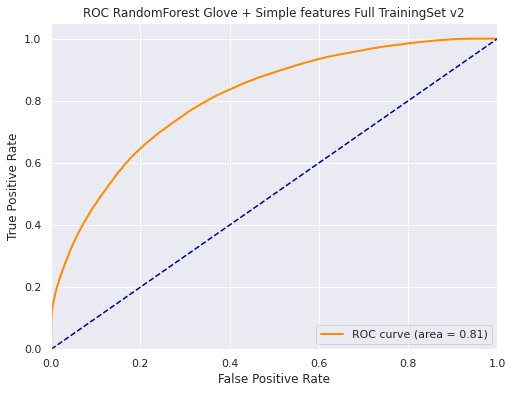

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

plt.figure(figsize=(8,6))
lw = 2
plt.plot(rf_fpr, rf_tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % area)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC RandomForest Glove + Simple features Full TrainingSet v2')
plt.legend(loc="lower right")
plt.savefig('ROC_RandomForest_glove_simplefeats_full2.jpg')

In [45]:
feature_importance_df = pd.DataFrame(rf.feature_importances_)
top_10_features = feature_importance_df.sort_values(0, ascending=False).iloc[:10]

In [46]:
num_feature_df = pd.DataFrame(chosen_features, columns=['feature']).reset_index()
top_10_features_df = top_10_features.reset_index().merge(num_feature_df, 'left')
top_10_features_df

,index,0,feature
0,8,0.097546,dale_chall_score
1,0,0.024048,aoa
2,9,0.016808,conc_subtlex_score
3,6,0.013917,syllable_per_word
4,2,0.012007,verb2
5,7,0.011643,conc_mean_score
6,79,0.011618,NaN
7,4,0.011267,aoa_perc_known_lem
8,65,0.010937,NaN
9,68,0.010429,NaN


In [44]:
top_10_features_df.to_csv('feature_importance_rf.csv')

# Test how BERT behave with this Testing dataset

In [ ]:
import tensorflow as tf
!pip install tensorflow_text
import tensorflow_text as text
import pandas as pd


saved_model_path='drive/MyDrive/Milestone2/wiki_difficulty_classification_bert_v2'
reloaded_model = tf.saved_model.load(saved_model_path)

In [56]:
Train_original_text = df_original.original_text[ind_train]
Test_original_text = df_original.original_text[ind_test]
Test_original_text.shape

(125031,)

In [60]:
from tqdm import tqdm

results_all = []
for i in tqdm(range(1,2502)):
    res = tf.sigmoid(reloaded_model(tf.constant(Test_original_text[(i-1)*50:i*50])))
    results_all.append(res)

100%|██████████| 1/1 [00:00<00:00,  1.74it/s]


In [61]:
results_all2 = np.vstack(results_all)
bert_preds = np.ndarray.flatten((results_all2>0.5)*1)

In [63]:
bert_acc = accuracy_score(Test_Y, bert_preds)*100
bert_f1 = f1_score(Test_Y, bert_preds)*100
bert_acc, bert_f1

(87.02881685342035, 87.63777726960896)

In [65]:
bert_fpr, bert_tpr, thresholds = roc_curve(Test_Y, results_all2, pos_label=1)
bert_area = auc(bert_fpr, bert_tpr)

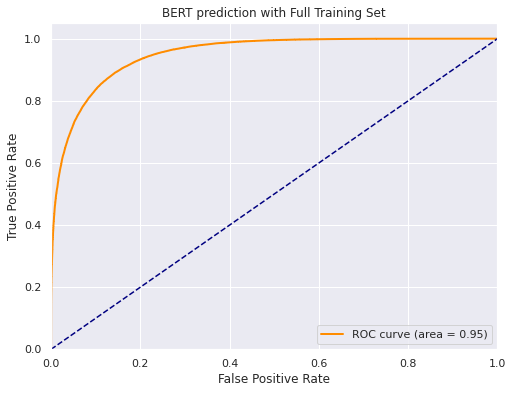

In [66]:
plt.figure(figsize=(8,6))
lw = 2
plt.plot(bert_fpr, bert_tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % bert_area)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('BERT prediction with Full Training Set')
plt.legend(loc="lower right")
plt.savefig('ROC_BERT_full.jpg')